In [1]:
import pandas as pd
import fuzzy  
from metaphone import doublemetaphone
import unidecode
from jellyfish import jaro_winkler_similarity, damerau_levenshtein_distance
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

## Sección 3
Genera un dataset sintético de nombres en español que contenga al menos 20 personas diferentes y que cada nombre aparezca de 3 formas distintas.

In [2]:
df_names = pd.read_csv('nombres.csv')
df_names.head()

,nombre_completo,edad,carrera,semestre
0,Juan Pérez,22,Ingeniería Civil,5
1,Juan Perezz,22,Ingeniería Civil,5
2,Jhuan Peres,22,Ingeniería Civil,5
3,María González,24,Medicina,7
4,Maria Gonzzalez,24,Medicina,7


a) Utiliza técnicas de preprocesamiento (limpieza y algoritmos fonéticos) y tres algoritmos de comparación difusa para agrupar correctamente las 3 formas de cada uno de los 20 nombres.

In [3]:
# 1. Limpieza de nombres
def normalize_name(name):
    """Convierte el nombre a minúsculas y elimina acentos."""
    return unidecode.unidecode(name.lower())

df_names['nombre_limpio'] = df_names['nombre_completo'].apply(normalize_name)
df_names.head()

,nombre_completo,edad,carrera,semestre,nombre_limpio
0,Juan Pérez,22,Ingeniería Civil,5,juan perez
1,Juan Perezz,22,Ingeniería Civil,5,juan perezz
2,Jhuan Peres,22,Ingeniería Civil,5,jhuan peres
3,María González,24,Medicina,7,maria gonzalez
4,Maria Gonzzalez,24,Medicina,7,maria gonzzalez


In [4]:
# 2. Algoritmos fonéticos
def aplicar_algoritmos(nombre):
    soundex = fuzzy.Soundex(4)  # Longitud del código Soundex
    return {
        'soundex': soundex(nombre),
        'nysiis': fuzzy.nysiis(nombre),
        'metaphone': doublemetaphone(nombre)[0]
    }

algoritmos = df_names['nombre_limpio'].apply(aplicar_algoritmos).apply(pd.Series)
df_names = pd.concat([df_names, algoritmos], axis=1)
df_names.head()

,nombre_completo,edad,carrera,semestre,nombre_limpio,soundex,nysiis,metaphone
0,Juan Pérez,22,Ingeniería Civil,5,juan perez,J516,JANPAR,JNPRS
1,Juan Perezz,22,Ingeniería Civil,5,juan perezz,J516,JANPAR,JNPRS
2,Jhuan Peres,22,Ingeniería Civil,5,jhuan peres,J516,JANPAR,JNPRS
3,María González,24,Medicina,7,maria gonzalez,M625,MARAGANSAL,MRKNSLS
4,Maria Gonzzalez,24,Medicina,7,maria gonzzalez,M625,MARAGANSAL,MRKNSLS


b) Los algoritmos de comparación difusa que se deben utilizar son:
   * Jaro-Winkler
   * Demerau-Levenshtein

In [5]:
def compare_names_jw(name1, name2):
    """Calcula la similitud Jaro-Winkler entre dos nombres."""
    return jaro_winkler_similarity(normalize_name(name1), normalize_name(name2))

def compare_names_dl(name1, name2):
    """Calcula la distancia Damerau-Levenshtein entre dos nombres."""
    return damerau_levenshtein_distance(normalize_name(name1), normalize_name(name2))


In [6]:
threshold_jw = 0.9  # Umbral de similitud Jaro-Winkler
threshold_dl = 2  # Umbral de distancia Damerau-Levenshtein

unique_rows = []
for i in range(0, len(df_names), 3):
    base_name = df_names.loc[i, "nombre_completo"]
    edad = df_names.loc[i, "edad"]
    carrera = df_names.loc[i, "carrera"]
    semestre = df_names.loc[i, "semestre"]
    similar = True
    
    for j in range(i + 1, i + 3):
        jw_score = compare_names_jw(df_names.loc[i, "nombre_completo"], df_names.loc[j, "nombre_completo"])
        dl_score = compare_names_dl(df_names.loc[i, "nombre_completo"], df_names.loc[j, "nombre_completo"])
        
        if jw_score < threshold_jw or dl_score > threshold_dl:
            similar = False
            break
    
    if similar:
        unique_rows.append({
            "nombre_completo": base_name,
            "edad": edad,
            "carrera": carrera,
            "semestre": semestre
        })

df_cleaned = pd.DataFrame(unique_rows)
df_cleaned

,nombre_completo,edad,carrera,semestre
0,Juan Pérez,22,Ingeniería Civil,5
1,María González,24,Medicina,7
2,Carlos López,20,Administración,3
3,Ana Martínez,21,Derecho,4
4,Luis Ramírez,23,Arquitectura,6
5,Sofía Hernández,19,Psicología,2
6,Jorge Gutiérrez,25,Ingeniería Industrial,8
7,Patricia Sánchez,22,Contaduría,5
8,Ricardo Torres,20,Biología,3
9,Gabriela Mendoza,21,Enfermería,4


## Ejercicio extra
Realizar la sección 3 inciso b) utilizando los algoritmos
   * Cosine distance
   * Cosine similarity

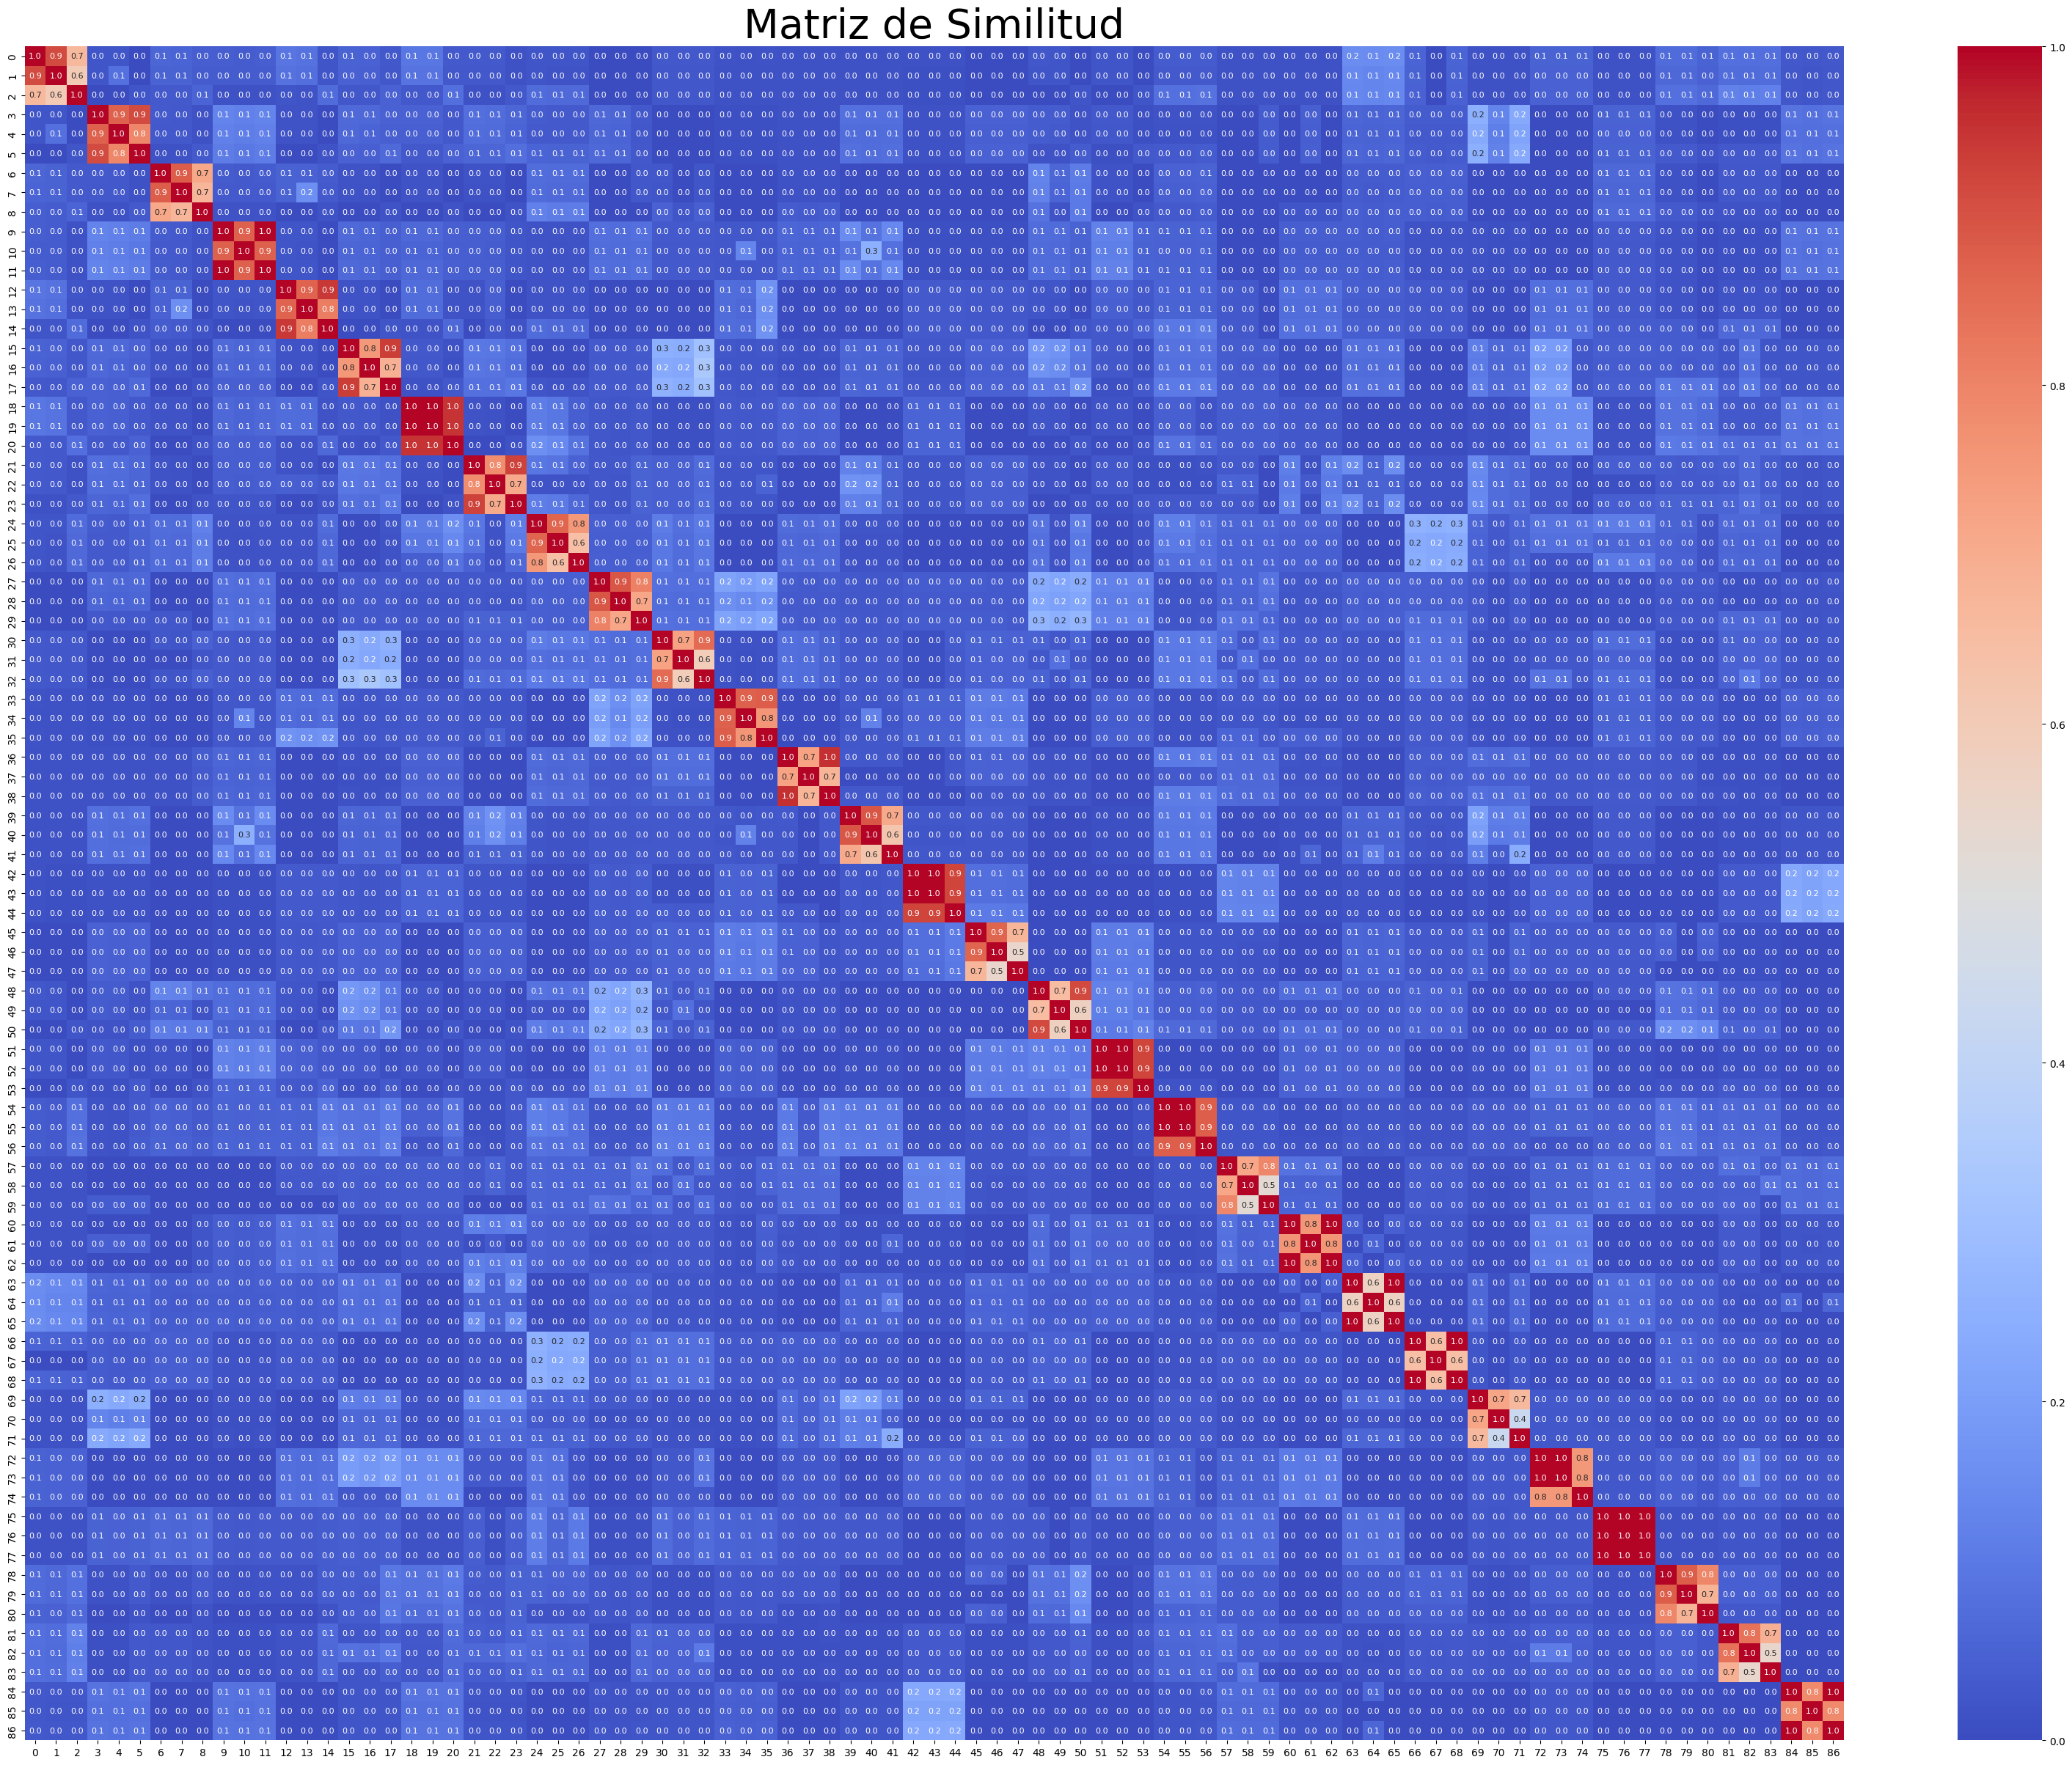

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_distances, cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt
vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(2,3))
X = vectorizer.fit_transform(df_names['nombre_limpio'])
similitud = cosine_similarity(X)
distancia_coseno = cosine_distances(X)
records_to_delete = set()
for i in range(similitud.shape[0]):
    if i in records_to_delete:
        continue
    row_sim = similitud[i].copy()
    row_sim[i] = 0  # Ignorar la similitud consigo mismo
    similar_idxs = np.where(row_sim > 0.5)[0]
    records_to_delete.update(similar_idxs)

df_cleaned_similarity = df_names.drop(index=list(records_to_delete)).reset_index(drop=True)
plt.figure(figsize=(40,30))
sns.heatmap(similitud, cmap='coolwarm', annot=True, fmt='.1f', cbar=True,annot_kws={"size": 8})
plt.title('Matriz de Similitud', fontsize=40)
plt.show()

In [8]:
df_cleaned_similarity[['nombre_completo', 'edad', 'carrera', 'semestre']]

,nombre_completo,edad,carrera,semestre
0,Juan Pérez,22,Ingeniería Civil,5
1,María González,24,Medicina,7
2,Carlos López,20,Administración,3
3,Ana Martínez,21,Derecho,4
4,Luis Ramírez,23,Arquitectura,6
5,Sofía Hernández,19,Psicología,2
6,Jorge Gutiérrez,25,Ingeniería Industrial,8
7,Patricia Sánchez,22,Contaduría,5
8,Ricardo Torres,20,Biología,3
9,Gabriela Mendoza,21,Enfermería,4


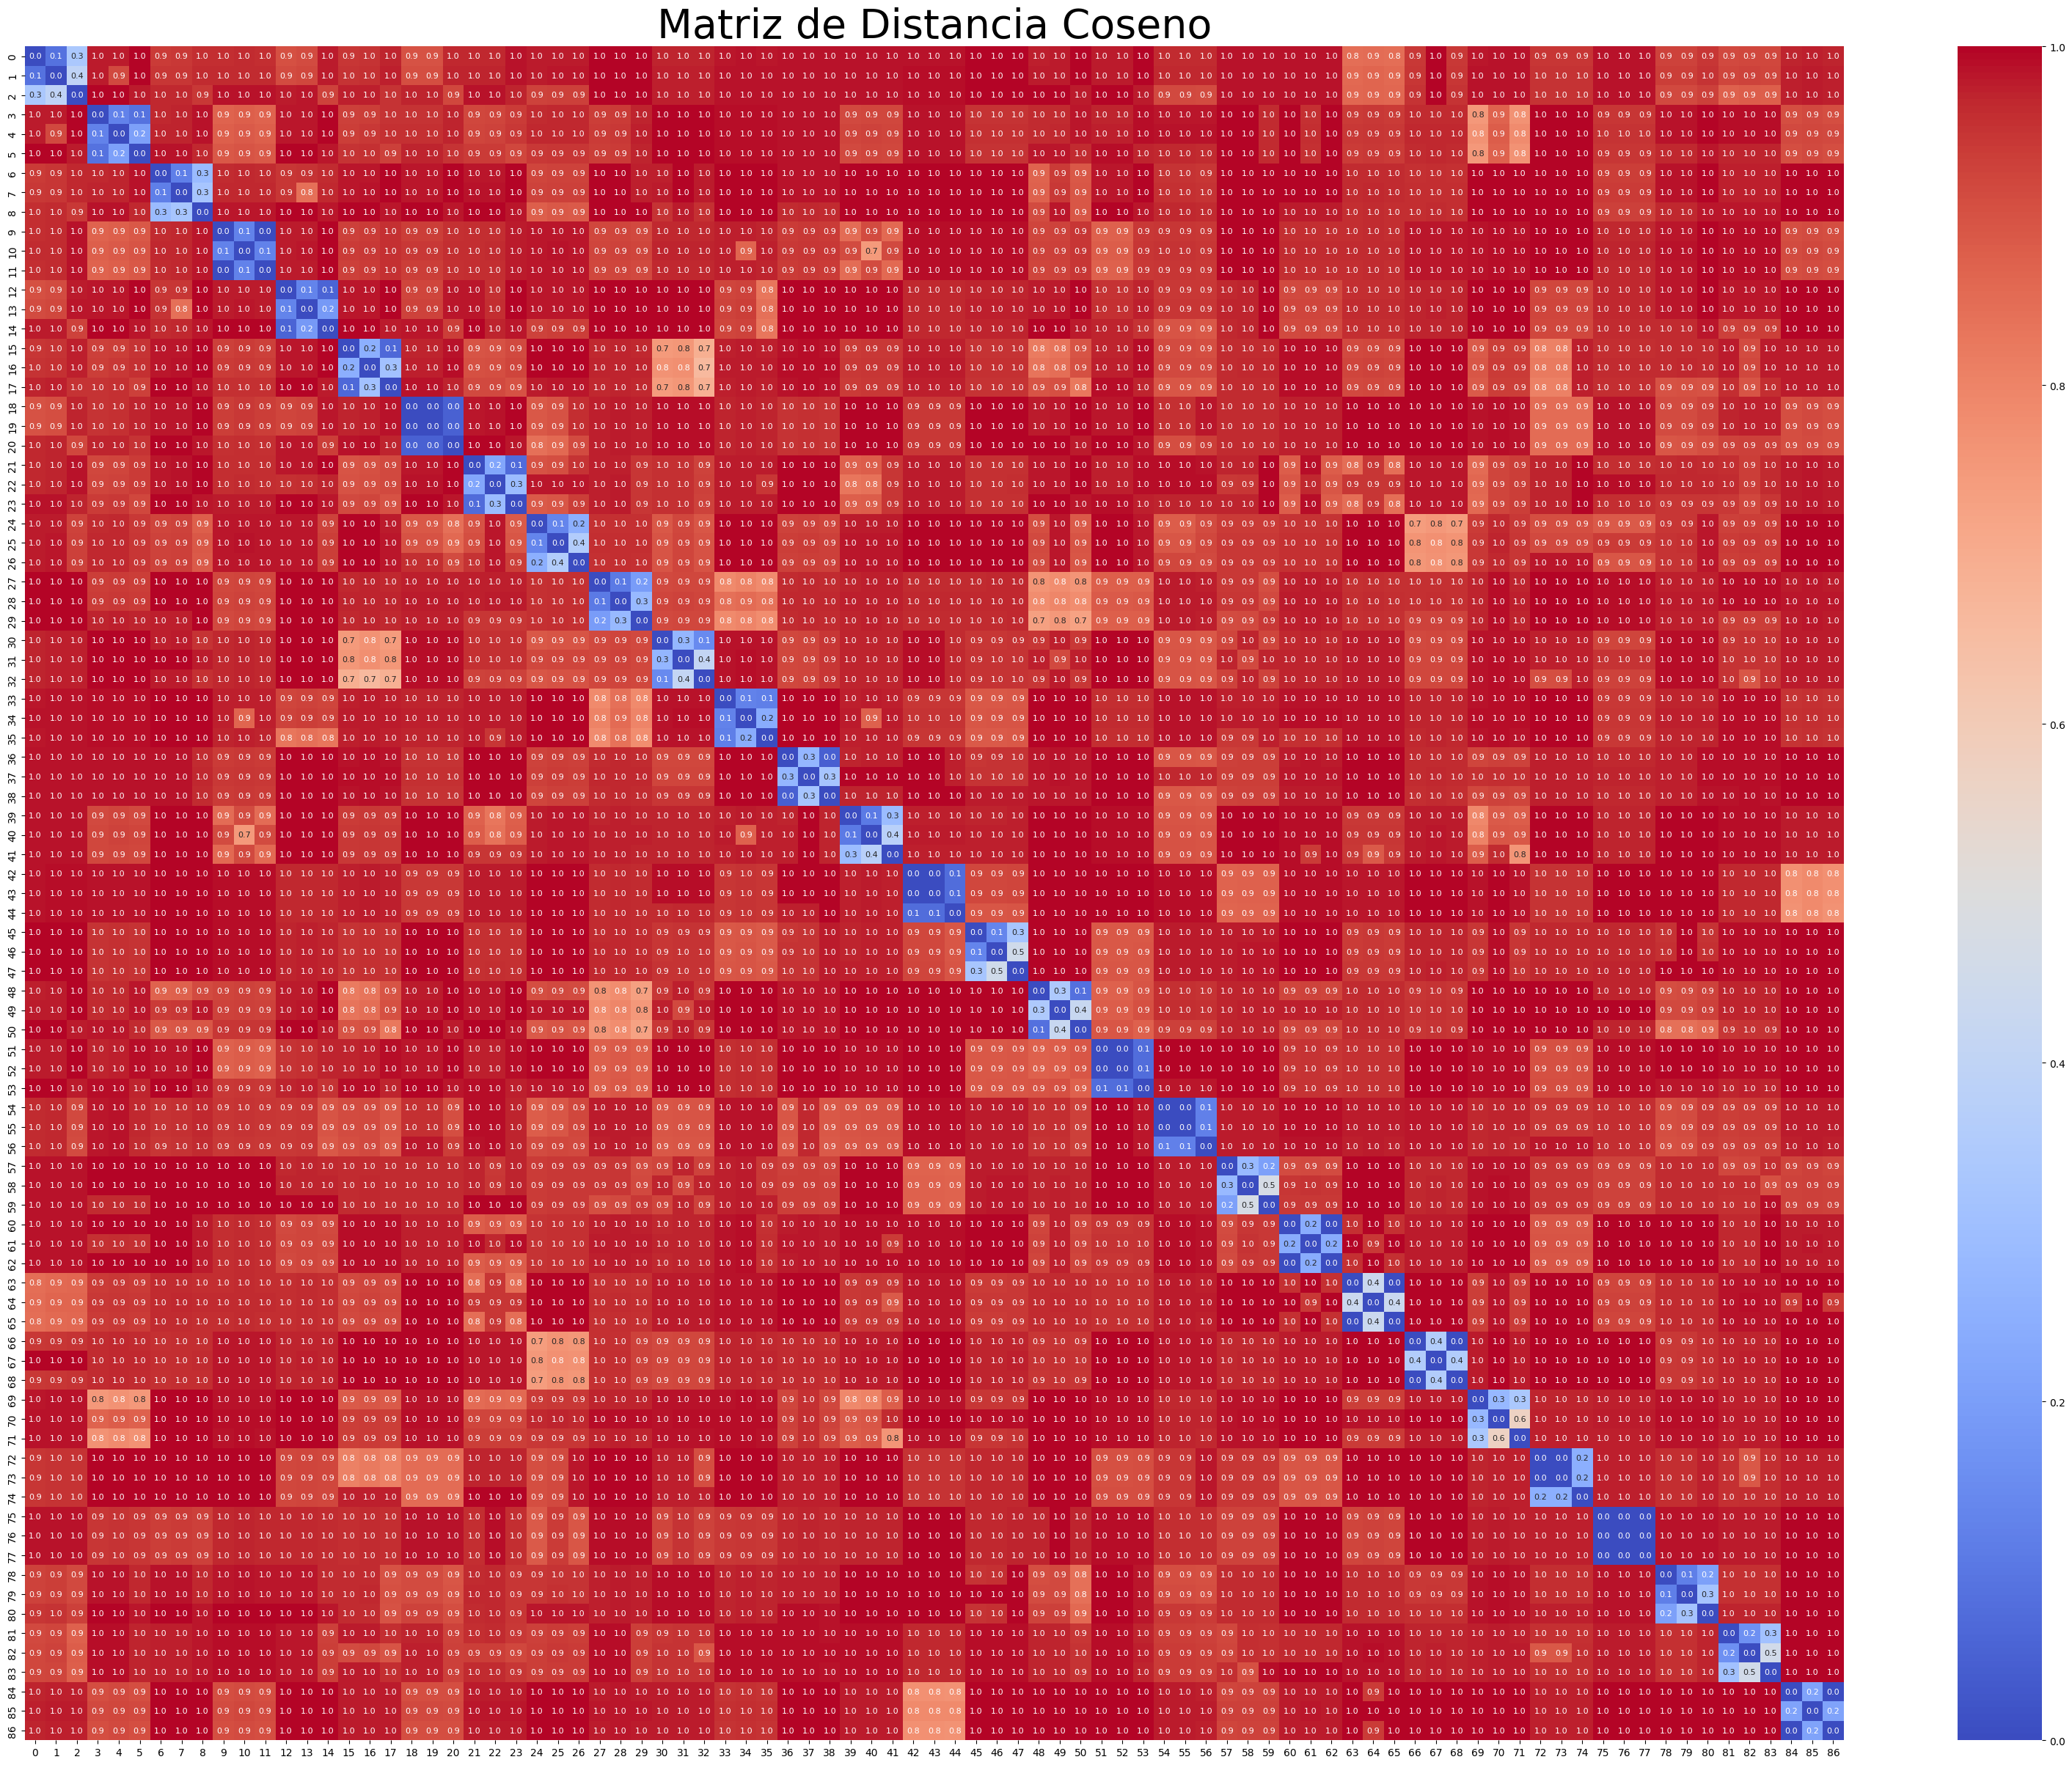

In [9]:
plt.figure(figsize=(40,30))
sns.heatmap(distancia_coseno, cmap='coolwarm', annot=True, fmt='.1f', cbar=True,annot_kws={"size": 8})
plt.title('Matriz de Distancia Coseno', fontsize=40)
plt.show()

In [10]:
indices_a_eliminar = set()
for i, fila in enumerate(distancia_coseno):
    if i in indices_a_eliminar:
        continue
    fila_mod = fila.copy()
    fila_mod[i] = 1
    indices_similares = np.where(fila_mod < 0.75)[0]
    indices_a_eliminar.update(indices_similares)

df_cleaned_cosine = df_names.drop(index=list(indices_a_eliminar)).reset_index(drop=True)
df_cleaned_cosine[['nombre_completo', 'edad', 'carrera', 'semestre']]

,nombre_completo,edad,carrera,semestre
0,Juan Pérez,22,Ingeniería Civil,5
1,María González,24,Medicina,7
2,Carlos López,20,Administración,3
3,Ana Martínez,21,Derecho,4
4,Luis Ramírez,23,Arquitectura,6
5,Sofía Hernández,19,Psicología,2
6,Jorge Gutiérrez,25,Ingeniería Industrial,8
7,Patricia Sánchez,22,Contaduría,5
8,Ricardo Torres,20,Biología,3
9,Gabriela Mendoza,21,Enfermería,4
